In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [474]:
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
# Load the dataset
types = {'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': int, 'InvoiceDate': str, 'UnitPrice': float, 'CustomerID': float, 'Country': str}
data = pd.read_csv('Online_Retail.csv', dtype=types, usecols=columns)

## Data preprocessing

In [475]:
prep_data = data[~data['InvoiceNo'].str.startswith('C')] # remove cancelled orders

In [476]:
prep_data.dropna(inplace=True) # remove rows with missing values

prep_data.drop_duplicates(inplace=True) # remove duplicate rows

In [477]:
prep_data['TotalPrice'] = prep_data['Quantity'] * prep_data['UnitPrice'] # calculate total price
prep_data['InvoiceDate'] = pd.to_datetime(prep_data['InvoiceDate']) # convert InvoiceDate to datetime




In [478]:
#remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
prep_data = remove_outliers(prep_data, 'TotalPrice') # remove outliers in TotalPrice
prep_data = remove_outliers(prep_data, 'Quantity') # remove outliers in Quantity
prep_data = remove_outliers(prep_data, 'UnitPrice') # remove outliers in UnitPrice


#### RFM prepration

In [479]:
RFM = prep_data.groupby(
    ['CustomerID']
).agg(
    {
        'InvoiceDate': lambda x: (prep_data['InvoiceDate'].max() - x.max()).days,
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'
    }
)
RFM.columns = ['Recency', 'Frequency', 'Monetary']

In [480]:
for metric in ['Recency', 'Frequency', 'Monetary']:
    RFM = remove_outliers(RFM, metric)

In [481]:
# from sklearn.preprocessing import StandardScaler
# RFM['Avg_Order_Value'] = RFM['Monetary'] / RFM['Frequency']
# RFM['Recency_Freq_Ratio'] = RFM['Recency'] / RFM['Frequency']
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(RFM[['Recency', 'Frequency', 'Monetary', 'Avg_Order_Value', 'Recency_Freq_Ratio']])

#### Clustering

In [482]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

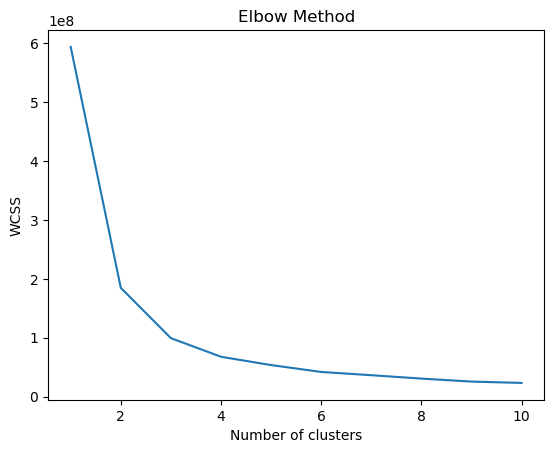

In [483]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(RFM)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [484]:
# Test different numbers of clusters and calculate silhouette scores
from sklearn.metrics import silhouette_score

for n in range(2, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(RFM)
    score = silhouette_score(RFM, labels)
    print(f"Number of Clusters: {n}, Silhouette Score: {score:.2f}")

Number of Clusters: 2, Silhouette Score: 0.63
Number of Clusters: 3, Silhouette Score: 0.53
Number of Clusters: 4, Silhouette Score: 0.47
Number of Clusters: 5, Silhouette Score: 0.40
Number of Clusters: 6, Silhouette Score: 0.41
Number of Clusters: 7, Silhouette Score: 0.42
Number of Clusters: 8, Silhouette Score: 0.39
Number of Clusters: 9, Silhouette Score: 0.40


In [485]:
k = 2  # Choose the number of clusters based on the elbow method and silhouette score

kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(RFM)

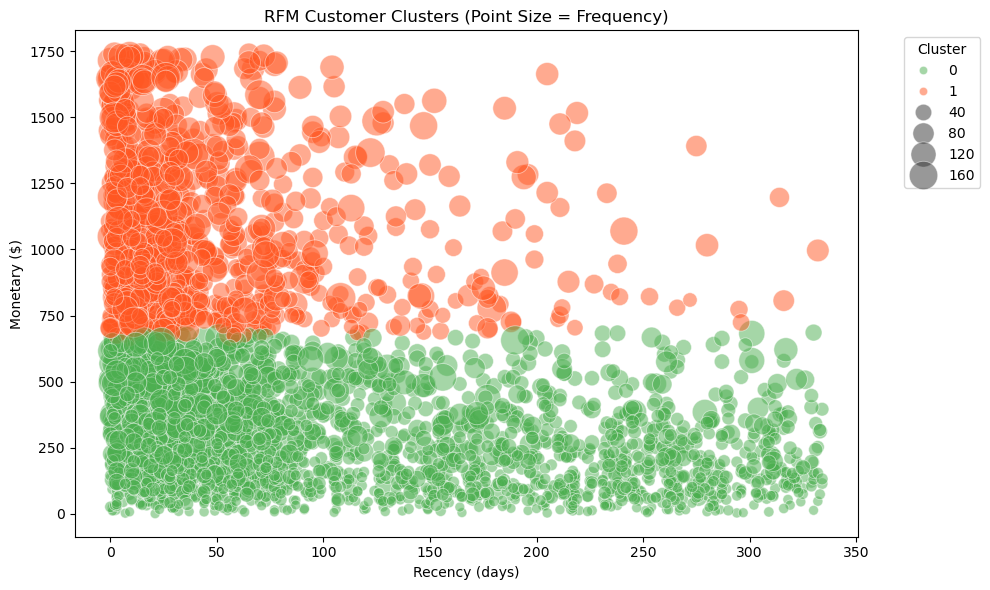

In [486]:


# Visualization 1: Scatter Plot (Recency vs. Monetary, Frequency as point size)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RFM, x='Recency', y='Monetary', hue=labels, 
                size='Frequency', sizes=(50, 500), palette=['#4CAF50', '#FF5722', '#2196F3', '#9E9E9E'], alpha=0.5)
plt.title('RFM Customer Clusters (Point Size = Frequency)')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

this is not a good clustering its simplyifying the customers into two groups only 

### Try scoring with RFM

In [501]:
RFM['R_score'] = pd.qcut(RFM['Recency'], 5, labels=[5, 4, 3, 2, 1])
RFM['F_score'] = pd.qcut(RFM['Frequency'], 5, labels=[1, 2, 3, 4, 5])
RFM['M_score'] = pd.qcut(RFM['Monetary'], 5, labels=[1, 2, 3, 4, 5])
RFM['RFM_Segment'] = RFM['R_score'].astype(str) + RFM['F_score'].astype(str) + RFM['M_score'].astype(str)


In [524]:
# Updated segment mapping
def assign_segment(rfm_score):
    if rfm_score in ['533', '534', '535', '543', '544', '545', '553', '554', '555']:
        return 'Champions'
    elif rfm_score in ['511', '512', '513', '521', '522', '523', '531', '532', '533', 
                       '541', '542', '543']:
        return 'New Customers'
    elif rfm_score in ['311', '312', '313', '321', '322', '323', '331', '332', '333', 
                       '411', '412', '413', '421', '422', '423', '431', '432', '433', 
                       '434', '435']:
        return 'Lost'
    elif rfm_score in ['111', '112', '113', '121', '122', '123', '131', '132', '133', 
                       '211', '212', '213', '221', '222', '223', '231', '232', '233']:
        return 'Churned'
    elif rfm_score in ['344', '345', '354', '355', '444', '445', '454', '455']:
        return 'Loyal but Inactive'
    elif rfm_score in ['234', '235', '244', '245', '254', '255']:
        return 'At Risk'
    elif rfm_score in ['334', '335', '434', '435', '443', '453', '454', '455']:
        return 'Regular Customers'
    else:
        return 'Potential Champions'  # Catch remaining scores as near-Champions

# Apply segment assignment
RFM['Segment'] = RFM['RFM_Segment'].apply(assign_segment)

<Axes: xlabel='Segment'>

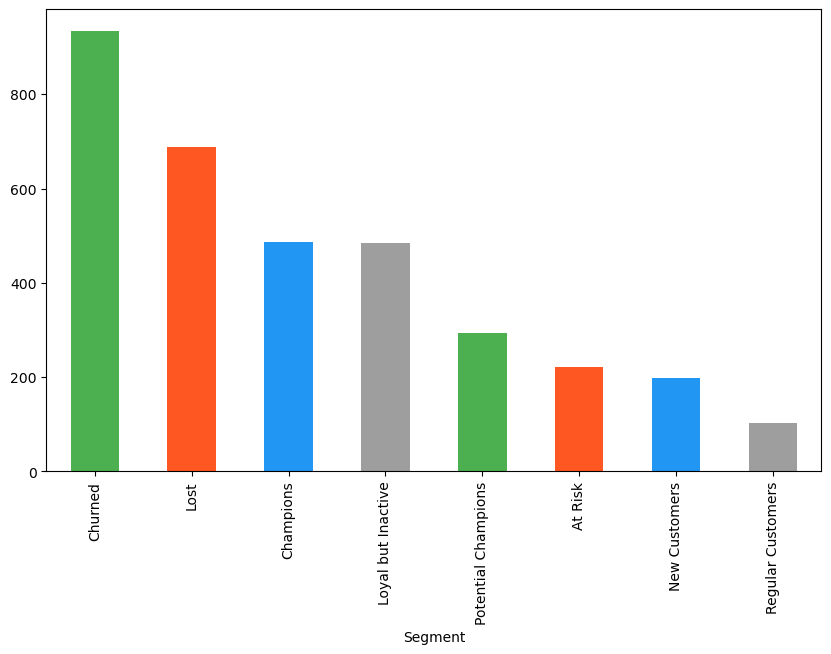

In [525]:

RFM['Segment'].value_counts().plot(kind='bar', figsize=(10, 6), color=['#4CAF50', '#FF5722', '#2196F3', '#9E9E9E'])

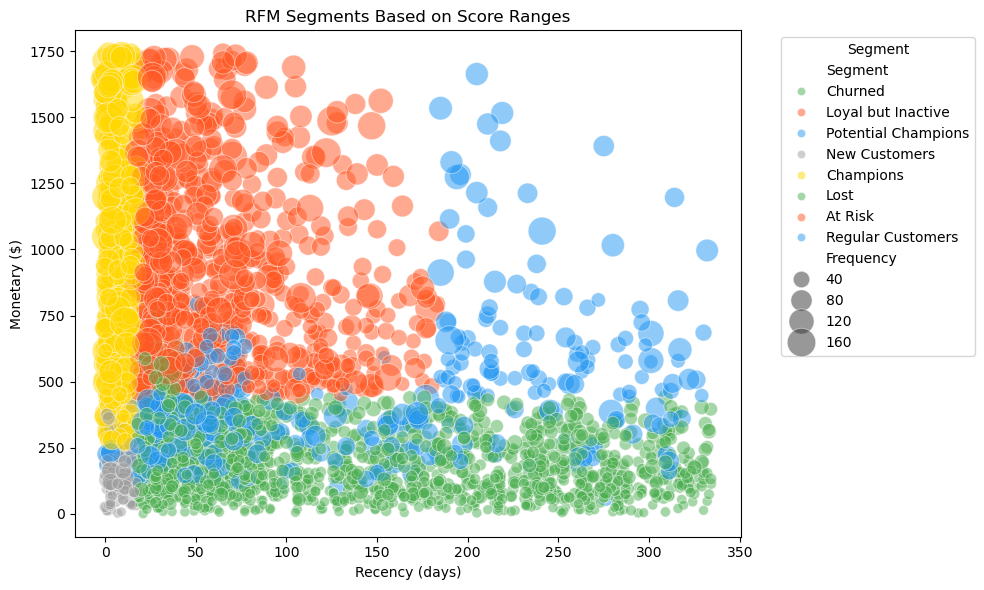

Segment Summary:
                         Recency  Frequency    Monetary  Count
Segment                                                      
At Risk              118.405405  59.770270  802.058063    222
Champions              8.000000  72.971193  871.563313    486
Churned              201.930332  13.010718  176.911929    933
Lost                  44.681223  16.617176  240.612958    687
Loyal but Inactive    41.500000  79.969008  953.205043    484
New Customers          8.879397  16.311558  181.773618    199
Potential Champions  157.765306  58.085034  435.404422    294
Regular Customers     46.776699  46.388350  480.655243    103


In [526]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RFM, x='Recency', y='Monetary', hue='Segment', 
                size='Frequency', sizes=(50, 500), palette=['#4CAF50', '#FF5722', '#2196F3', '#9E9E9E', '#FFD700'],alpha=0.5)
plt.title('RFM Segments Based on Score Ranges')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 5: Analyze segments
segment_summary = RFM.reset_index().groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})
print("Segment Summary:\n", segment_summary)

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,Segment,RFM_total
CustomerID,,,,,,,,,
12348.0,248,6,90.20,1,1,1,111,Churned,3
12349.0,18,57,939.75,4,4,5,445,Unassigned,13
12350.0,309,16,294.40,1,2,3,123,Churned,6
12352.0,35,66,1130.94,4,4,5,445,Unassigned,13
12353.0,203,2,29.30,1,1,1,111,Churned,3
...,...,...,...,...,...,...,...,...,...
18278.0,73,9,173.90,3,1,2,312,Lost,6
18280.0,277,8,137.00,1,1,2,112,Churned,4
18281.0,180,5,46.92,2,1,1,211,Churned,4
